In [14]:
import sys
import json
from pathlib import Path
import torch
import numpy as np
import meshplot as mp

root_dir = Path().resolve().parent
if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))

from joint.joint_prediction_set import JointPredictionSet
from joint.joint_environment import JointEnvironment
from datasets.joint_graph_dataset import JointGraphDataset
from train import JointPrediction

In [15]:
# Change to point to the Fusion 360 Gallery joint dataset
# this directory should contain the joint json and obj part files
data_dir = root_dir / "data/zw3d-joinable-dataset"

dataset = JointGraphDataset(
    root_dir=data_dir,
    split="train",
    center_and_scale=True,
    random_rotate=False,
    delete_cache=False,
    limit=0,
    threads=1,
    label_scheme="Joint",
    max_node_count=1024,
    input_features="axis_pos,axis_dir,bounding_box,entity_types,area,circumference,param_1,param_2,length,radius,start_point,middle_point,end_point",
    skip_far=False,
    skip_interference=False,
    skip_nurbs=False,
    joint_type="all",
    without_synthetic=False,
    feature_embedding=False,
    num_bits=9
)

No data cache available
Using official train test split
Loading 8812 train data


100%|██████████| 8812/8812 [10:09<00:00, 14.47it/s]


Total graph load time: 609.0708844661713 sec
Skipped: 295 files
Done loading 8517 files
Data cache written to: /home/fusiqiao/Projects/JoinABLe/data/zw3d-joinable-dataset/train.pickle


In [17]:
from collections import defaultdict
from tqdm import tqdm

face_features = (
    "area",
    "circumference",
    "param_1",
    "param_2",
)

edge_features = (
    "length",
    "radius"
)

edge_vector_features = (
    "start_point",
    "middle_point",
    "end_point"
)

vector_features = (
    "axis_pos",
    "axis_dir"
)

def default_ndarray():
    return np.array([])
feature_to_values = defaultdict(default_ndarray)

for g1, g2, jg in tqdm(dataset):
    g1_face_indices = torch.where(g1["is_face"] > 0.5)[0].long()
    g2_face_indices = torch.where(g2["is_face"] > 0.5)[0].long()
    g1_edge_indices = torch.where(g1["is_face"] < 0.5)[0].long()
    g2_edge_indices = torch.where(g2["is_face"] < 0.5)[0].long()
    for feature in face_features:
        feature_to_values[feature] = np.append(feature_to_values[feature], g1[feature][g1_face_indices].numpy())
        feature_to_values[feature] = np.append(feature_to_values[feature], g2[feature][g2_face_indices].numpy())

    for feature in edge_features:
        feature_to_values[feature] = np.append(feature_to_values[feature], g1[feature][g1_edge_indices].numpy())
        feature_to_values[feature] = np.append(feature_to_values[feature], g2[feature][g2_edge_indices].numpy())

    for feature in edge_vector_features:
        feature_to_values[feature + "_x"] = np.append(feature_to_values[feature + "_x"], g1[feature][g1_edge_indices,0].numpy())
        feature_to_values[feature + "_y"] = np.append(feature_to_values[feature + "_y"], g1[feature][g1_edge_indices,1].numpy())
        feature_to_values[feature + "_z"] = np.append(feature_to_values[feature + "_z"], g1[feature][g1_edge_indices,2].numpy())
        feature_to_values[feature + "_x"] = np.append(feature_to_values[feature + "_x"], g2[feature][g2_edge_indices,0].numpy())
        feature_to_values[feature + "_y"] = np.append(feature_to_values[feature + "_y"], g2[feature][g2_edge_indices,1].numpy())
        feature_to_values[feature + "_z"] = np.append(feature_to_values[feature + "_z"], g2[feature][g2_edge_indices,2].numpy())
    
    for feature in vector_features:
        feature_to_values[feature + "_x"] = np.append(feature_to_values[feature + "_x"], g1[feature][:,0].numpy())
        feature_to_values[feature + "_y"] = np.append(feature_to_values[feature + "_y"], g1[feature][:,1].numpy())
        feature_to_values[feature + "_z"] = np.append(feature_to_values[feature + "_z"], g1[feature][:,2].numpy())
        feature_to_values[feature + "_x"] = np.append(feature_to_values[feature + "_x"], g2[feature][:,0].numpy())
        feature_to_values[feature + "_y"] = np.append(feature_to_values[feature + "_y"], g2[feature][:,1].numpy())
        feature_to_values[feature + "_z"] = np.append(feature_to_values[feature + "_z"], g2[feature][:,2].numpy())

    feature_to_values["bounding_box" + "_max_x"] = np.append(feature_to_values["bounding_box" + "_max_x"], g1["bounding_box"][:,0].numpy())
    feature_to_values["bounding_box" + "_max_y"] = np.append(feature_to_values["bounding_box" + "_max_y"], g1["bounding_box"][:,1].numpy())
    feature_to_values["bounding_box" + "_max_z"] = np.append(feature_to_values["bounding_box" + "_max_z"], g1["bounding_box"][:,2].numpy())
    feature_to_values["bounding_box" + "_min_x"] = np.append(feature_to_values["bounding_box" + "_min_x"], g1["bounding_box"][:,3].numpy())
    feature_to_values["bounding_box" + "_min_y"] = np.append(feature_to_values["bounding_box" + "_min_y"], g1["bounding_box"][:,4].numpy())
    feature_to_values["bounding_box" + "_min_z"] = np.append(feature_to_values["bounding_box" + "_min_z"], g1["bounding_box"][:,5].numpy())
    
    feature_to_values["bounding_box" + "_max_x"] = np.append(feature_to_values["bounding_box" + "_max_x"], g2["bounding_box"][:,0].numpy())
    feature_to_values["bounding_box" + "_max_y"] = np.append(feature_to_values["bounding_box" + "_max_y"], g2["bounding_box"][:,1].numpy())
    feature_to_values["bounding_box" + "_max_z"] = np.append(feature_to_values["bounding_box" + "_max_z"], g2["bounding_box"][:,2].numpy())
    feature_to_values["bounding_box" + "_min_x"] = np.append(feature_to_values["bounding_box" + "_min_x"], g2["bounding_box"][:,3].numpy())
    feature_to_values["bounding_box" + "_min_y"] = np.append(feature_to_values["bounding_box" + "_min_y"], g2["bounding_box"][:,4].numpy())
    feature_to_values["bounding_box" + "_min_z"] = np.append(feature_to_values["bounding_box" + "_min_z"], g2["bounding_box"][:,5].numpy())

# for g1, g2, jg in tqdm(dataset):
#     M, N = g1.num_nodes, g2.num_nodes
#     g1_face_indices = torch.where(g1["is_face"] > 0.5)[0].long()
#     g2_face_indices = torch.where(g2["is_face"] > 0.5)[0].long()
#     g1_edge_indices = torch.where(g1["is_face"] < 0.5)[0].long()
#     g2_edge_indices = torch.where(g2["is_face"] < 0.5)[0].long()
#     for index in torch.argwhere(jg.edge_attr > 0).flatten():
#         id1, id2 = index // N, index % N
#         for feature in face_features:
#             if g1["is_face"][id1].float() > 0.5:
#                 feature_to_values[feature] = np.append(feature_to_values[feature], g1[feature][id1].numpy())
#             if g2["is_face"][id2].float() > 0.5:
#                 feature_to_values[feature] = np.append(feature_to_values[feature], g2[feature][id2].numpy())

#         for feature in edge_features:
#             if g1["is_face"][id1].float() < 0.5:
#                 feature_to_values[feature] = np.append(feature_to_values[feature], g1[feature][id1].numpy())
#             if g2["is_face"][id2].float() < 0.5:
#                 feature_to_values[feature] = np.append(feature_to_values[feature], g2[feature][id2].numpy())
        
#         for feature in vector_features:
#             feature_to_values[feature + "_x"] = np.append(feature_to_values[feature + "_x"], g1[feature][id1,0].numpy())
#             feature_to_values[feature + "_y"] = np.append(feature_to_values[feature + "_y"], g1[feature][id1,1].numpy())
#             feature_to_values[feature + "_z"] = np.append(feature_to_values[feature + "_z"], g1[feature][id1,2].numpy())
#             feature_to_values[feature + "_x"] = np.append(feature_to_values[feature + "_x"], g2[feature][id2,0].numpy())
#             feature_to_values[feature + "_y"] = np.append(feature_to_values[feature + "_y"], g2[feature][id2,1].numpy())
#             feature_to_values[feature + "_z"] = np.append(feature_to_values[feature + "_z"], g2[feature][id2,2].numpy())

#         feature_to_values["bounding_box" + "_min_x"] = np.append(feature_to_values["bounding_box" + "_min_x"], g1["bounding_box"][id1,0].numpy())
#         feature_to_values["bounding_box" + "_min_y"] = np.append(feature_to_values["bounding_box" + "_min_y"], g1["bounding_box"][id1,1].numpy())
#         feature_to_values["bounding_box" + "_min_z"] = np.append(feature_to_values["bounding_box" + "_min_z"], g1["bounding_box"][id1,2].numpy())
#         feature_to_values["bounding_box" + "_max_x"] = np.append(feature_to_values["bounding_box" + "_max_x"], g1["bounding_box"][id1,3].numpy())
#         feature_to_values["bounding_box" + "_max_y"] = np.append(feature_to_values["bounding_box" + "_max_y"], g1["bounding_box"][id1,4].numpy())
#         feature_to_values["bounding_box" + "_max_z"] = np.append(feature_to_values["bounding_box" + "_max_z"], g1["bounding_box"][id1,5].numpy())
        
#         feature_to_values["bounding_box" + "_min_x"] = np.append(feature_to_values["bounding_box" + "_min_x"], g2["bounding_box"][id2,0].numpy())
#         feature_to_values["bounding_box" + "_min_y"] = np.append(feature_to_values["bounding_box" + "_min_y"], g2["bounding_box"][id2,1].numpy())
#         feature_to_values["bounding_box" + "_min_z"] = np.append(feature_to_values["bounding_box" + "_min_z"], g2["bounding_box"][id2,2].numpy())
#         feature_to_values["bounding_box" + "_max_x"] = np.append(feature_to_values["bounding_box" + "_max_x"], g2["bounding_box"][id2,3].numpy())
#         feature_to_values["bounding_box" + "_max_y"] = np.append(feature_to_values["bounding_box" + "_max_y"], g2["bounding_box"][id2,4].numpy())
#         feature_to_values["bounding_box" + "_max_z"] = np.append(feature_to_values["bounding_box" + "_max_z"], g2["bounding_box"][id2,5].numpy())

100%|██████████| 8517/8517 [06:51<00:00, 20.69it/s]


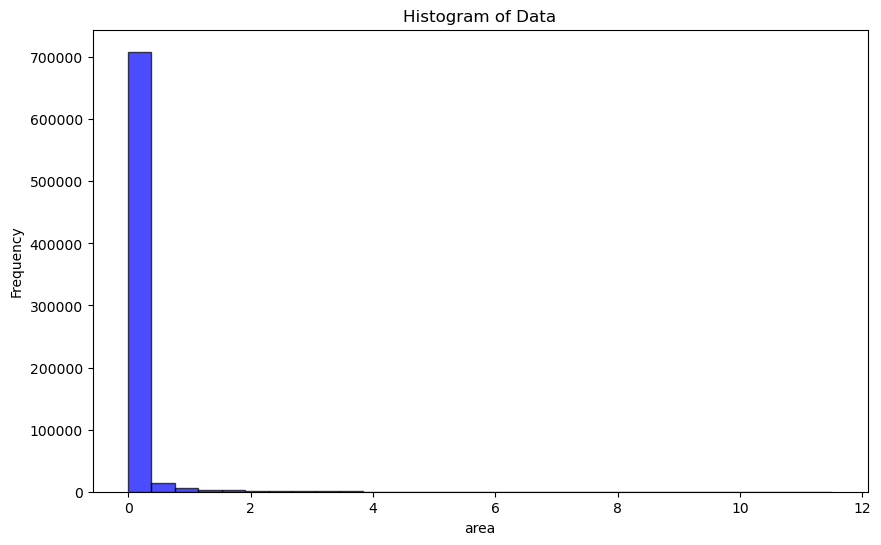

area 11.509769439697266


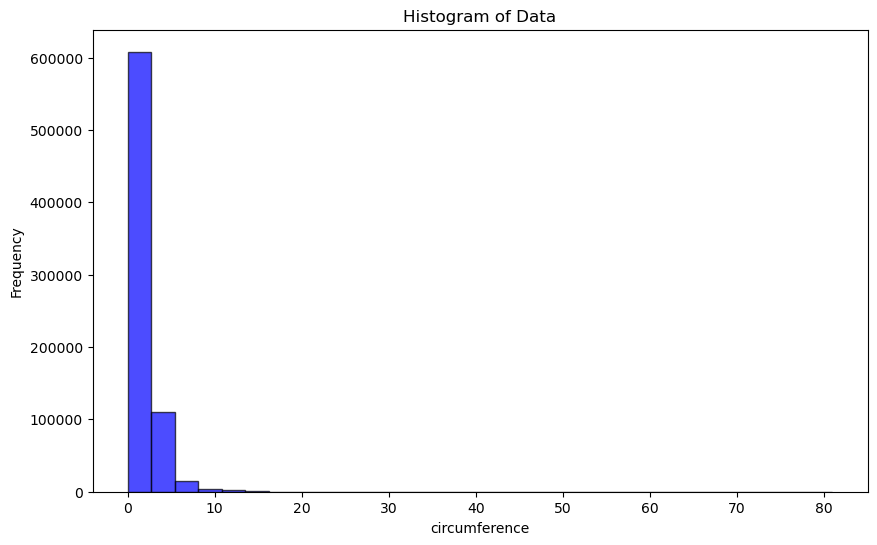

circumference 80.97926330566406


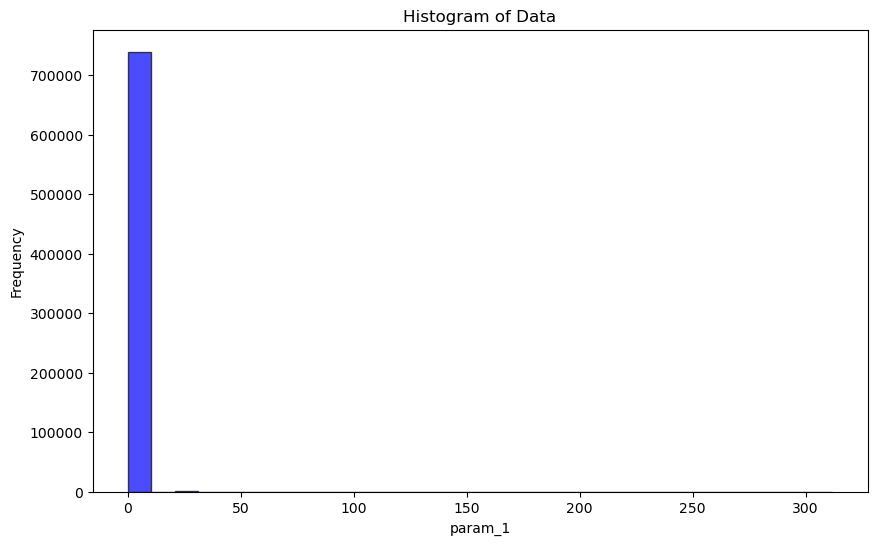

param_1 311.83599853515625


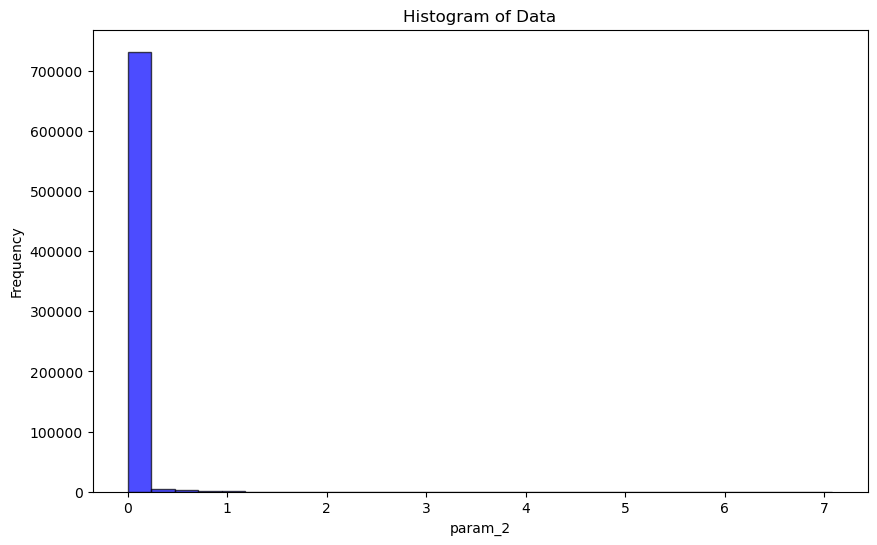

param_2 7.079414367675781


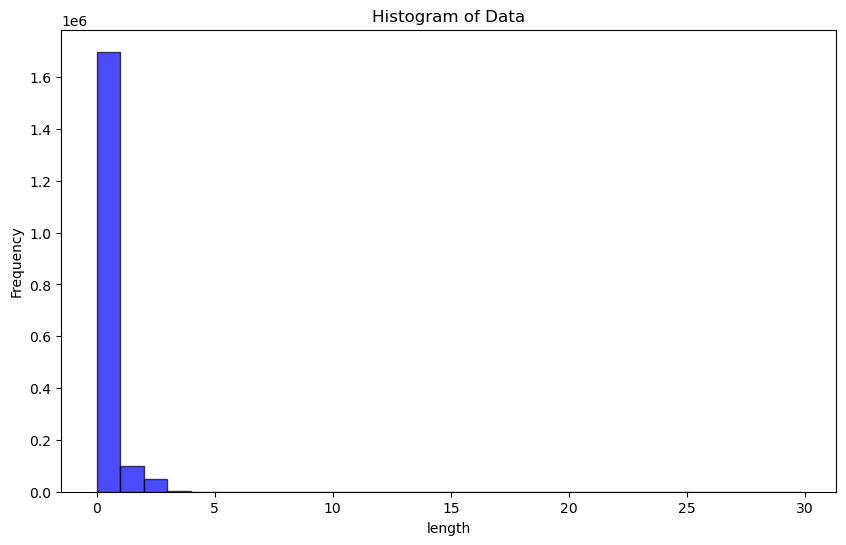

length 29.83692169189453


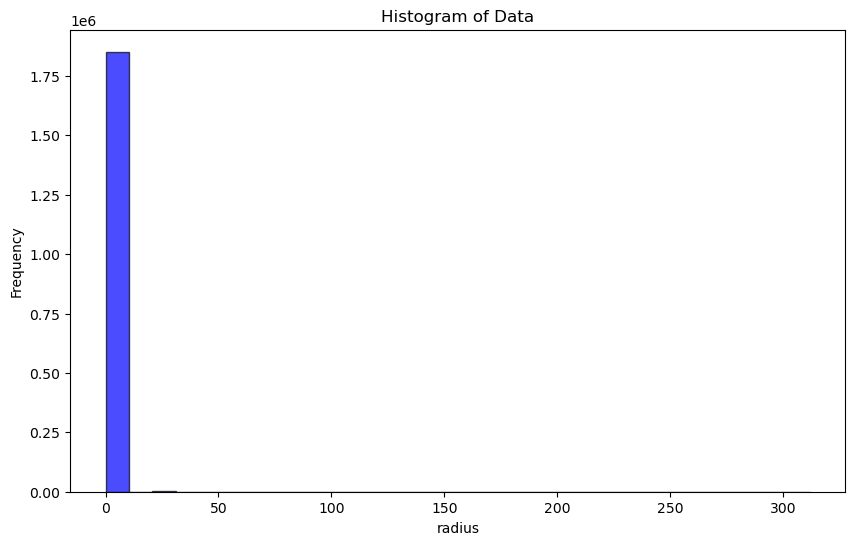

radius 311.83599853515625


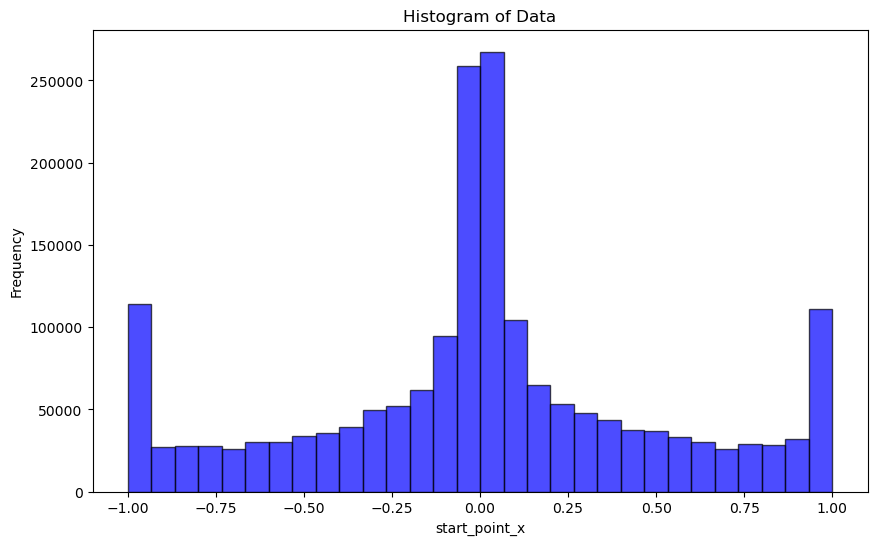

start_point_x 1.0000052452087402


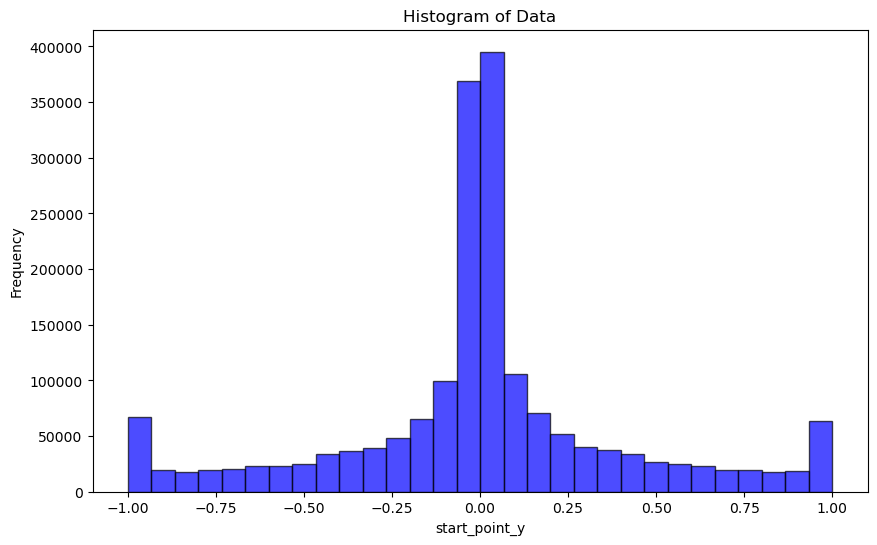

start_point_y 1.0000004768371582


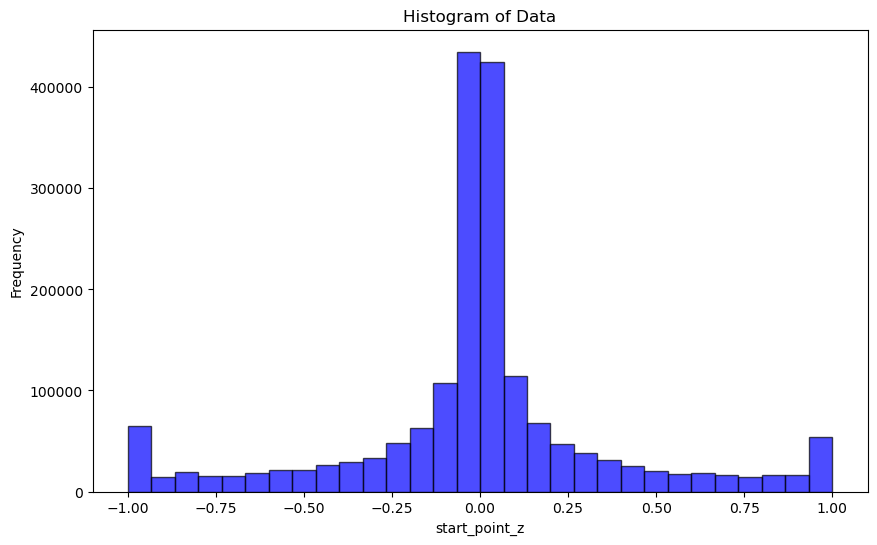

start_point_z 1.0000003576278687


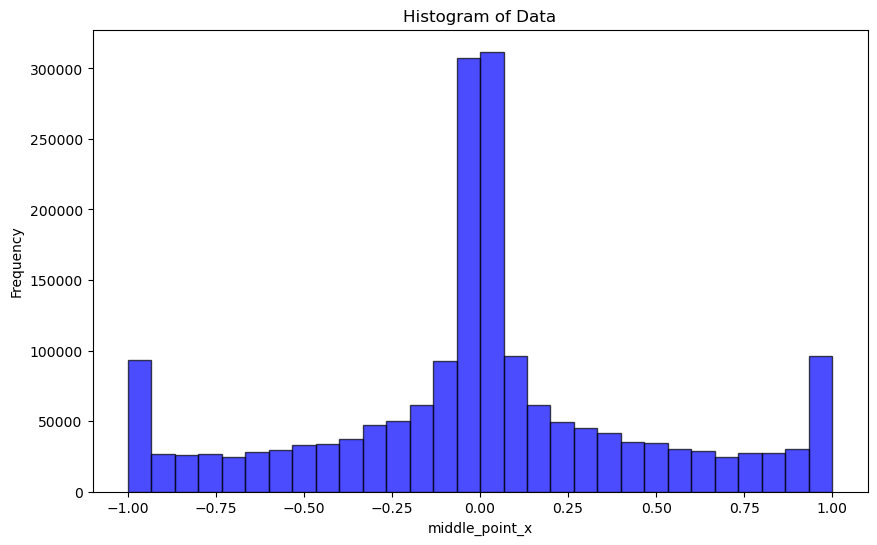

middle_point_x 1.0000001192092896


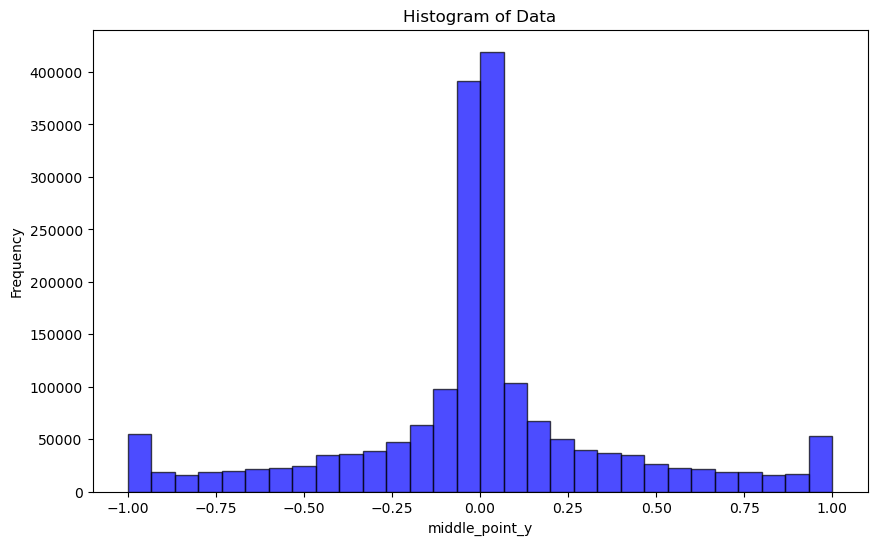

middle_point_y 1.0000004768371582


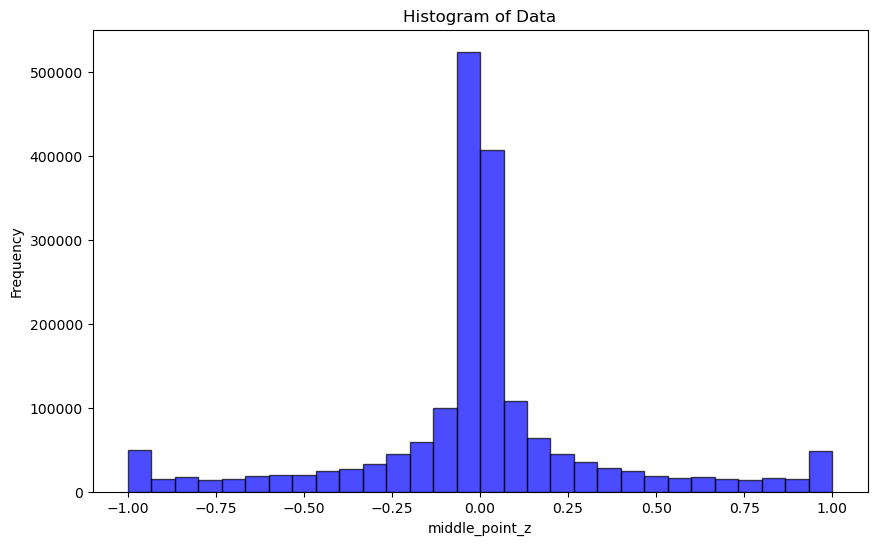

middle_point_z 1.0000003576278687


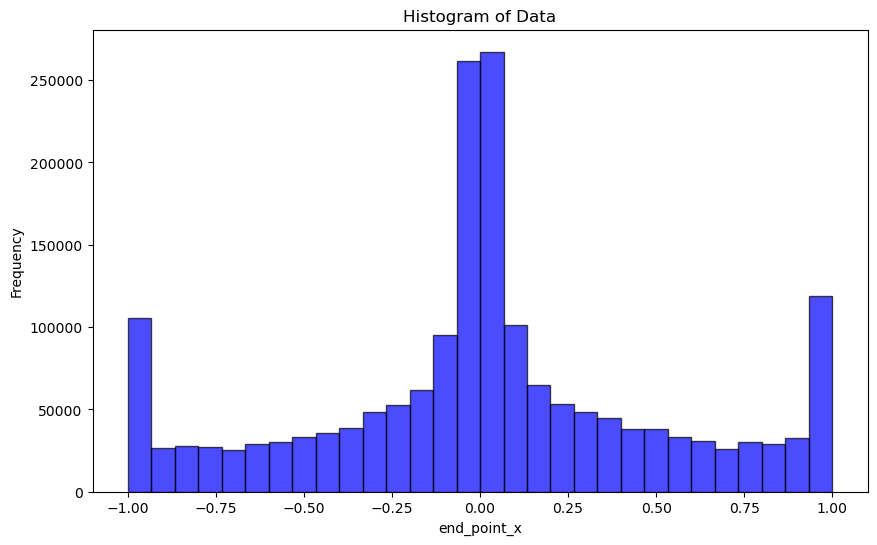

end_point_x 1.0000001192092896


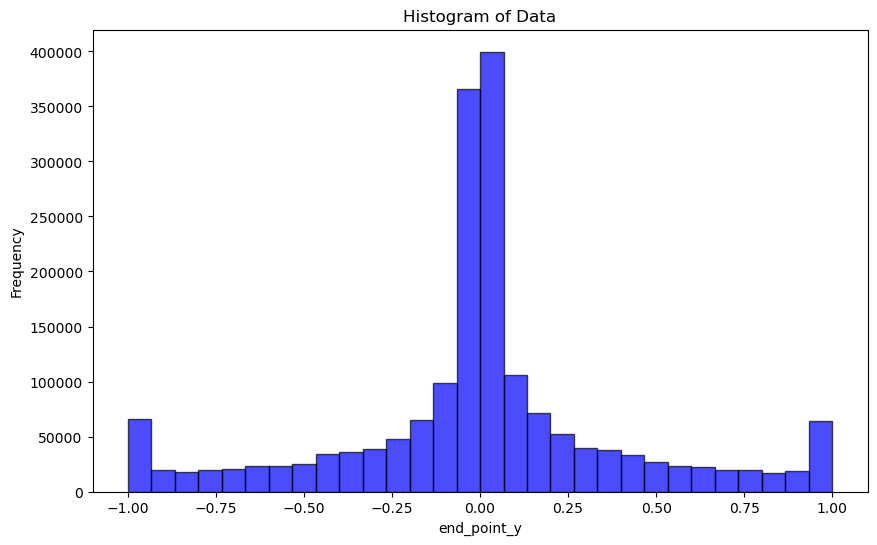

end_point_y 1.0000004768371582


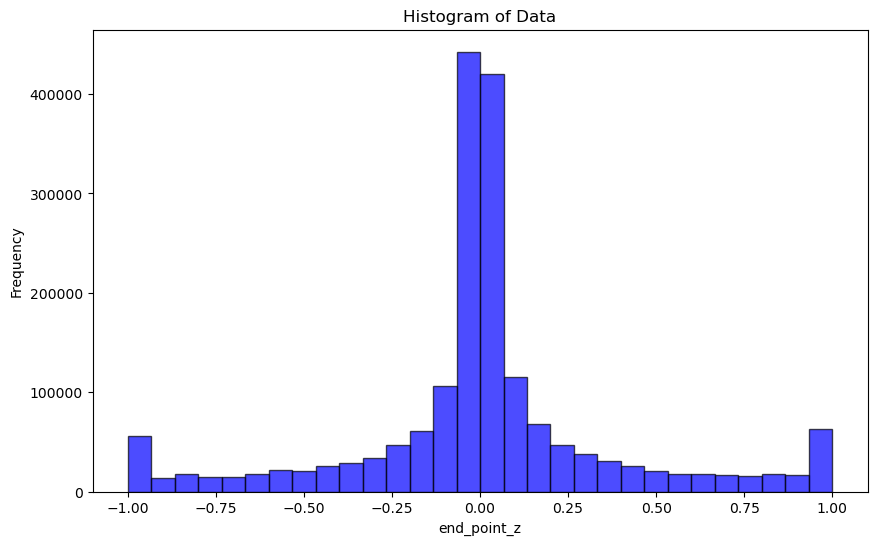

end_point_z 1.0000003576278687


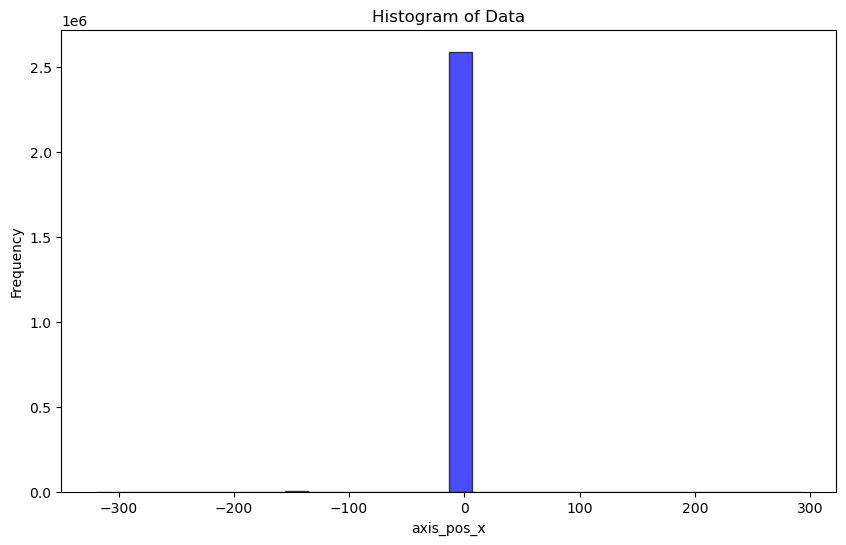

axis_pos_x 292.1576843261719


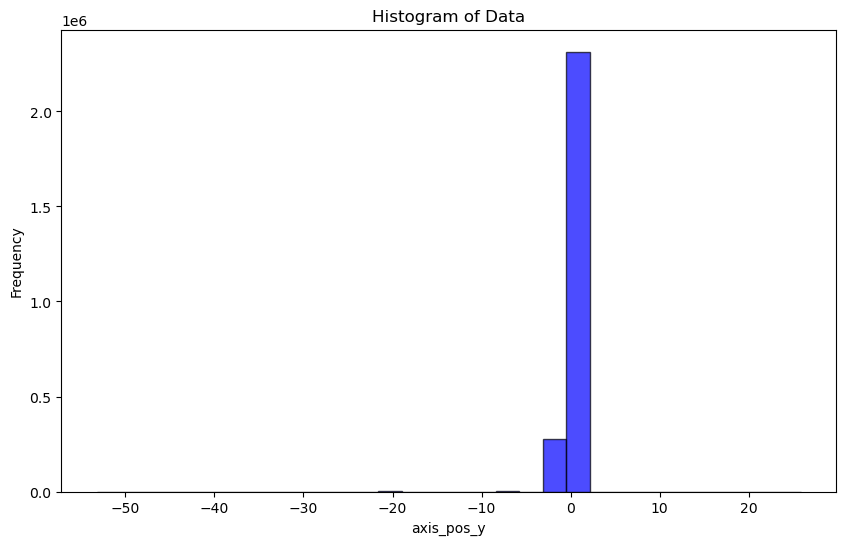

axis_pos_y 25.893701553344727


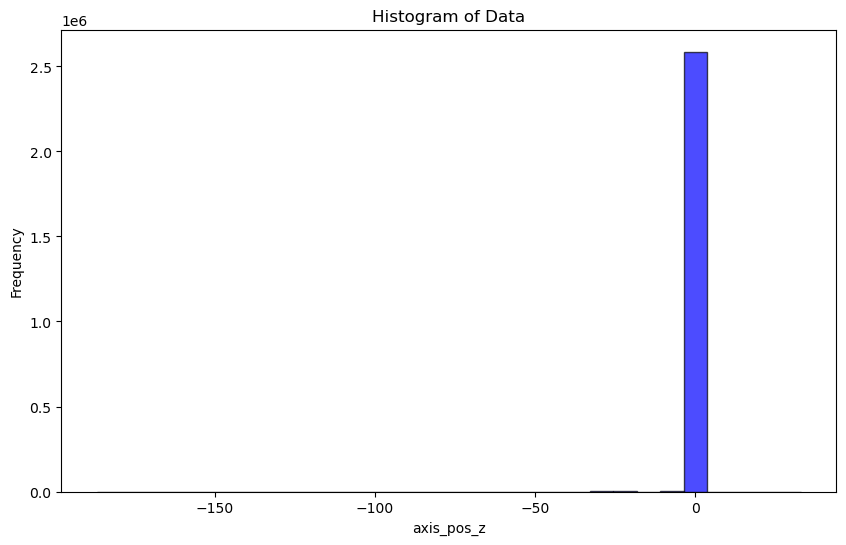

axis_pos_z 33.102779388427734


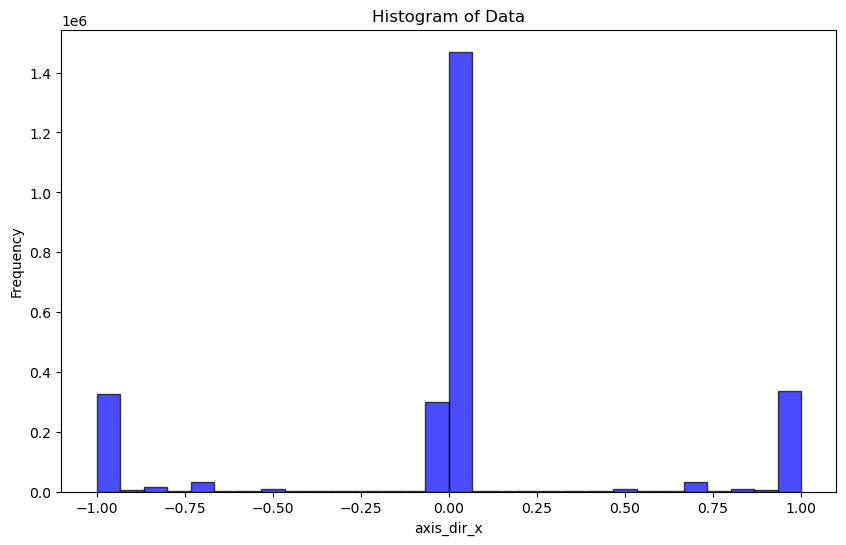

axis_dir_x 1.0


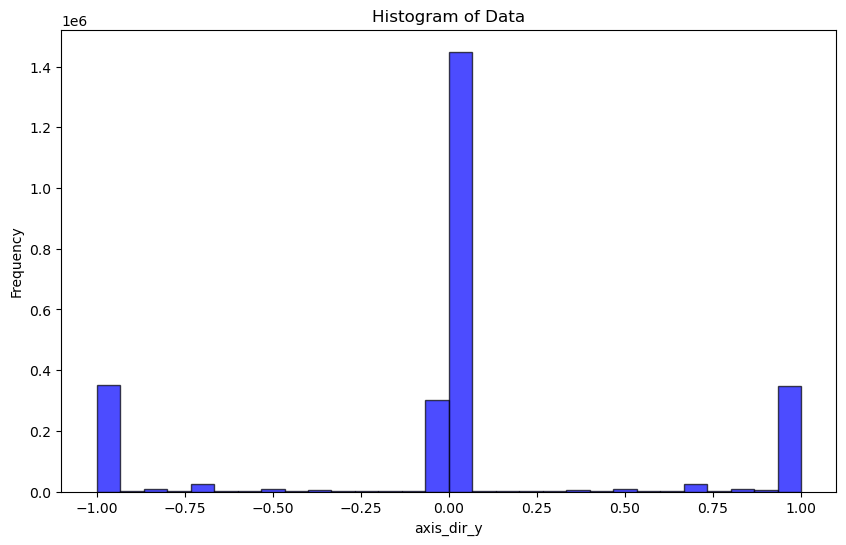

axis_dir_y 1.0


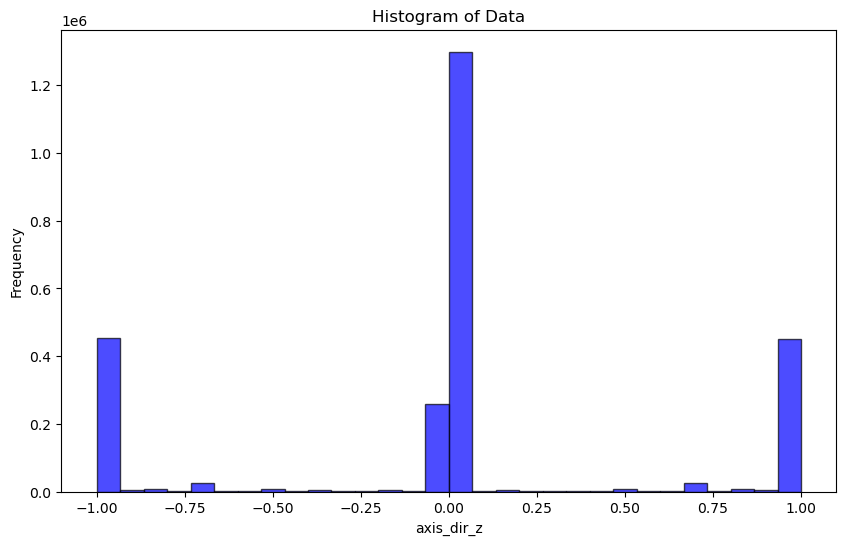

axis_dir_z 1.0


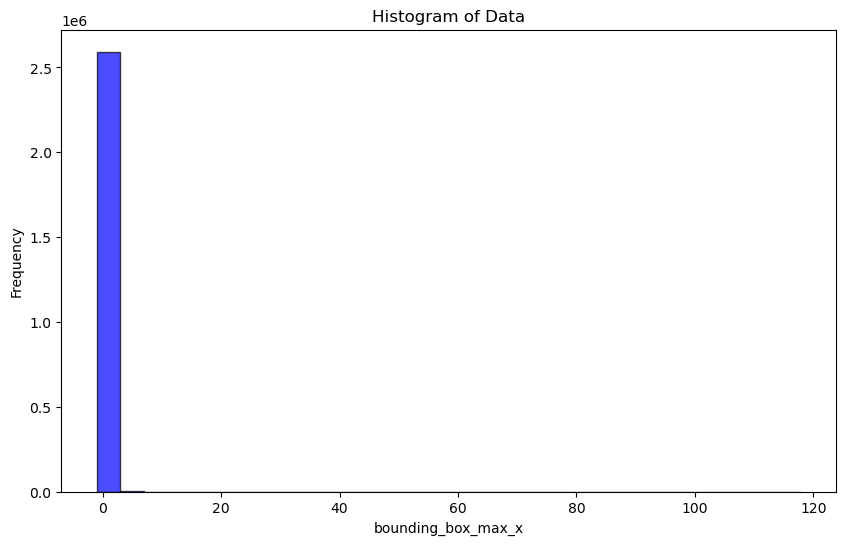

bounding_box_max_x 117.92984771728516


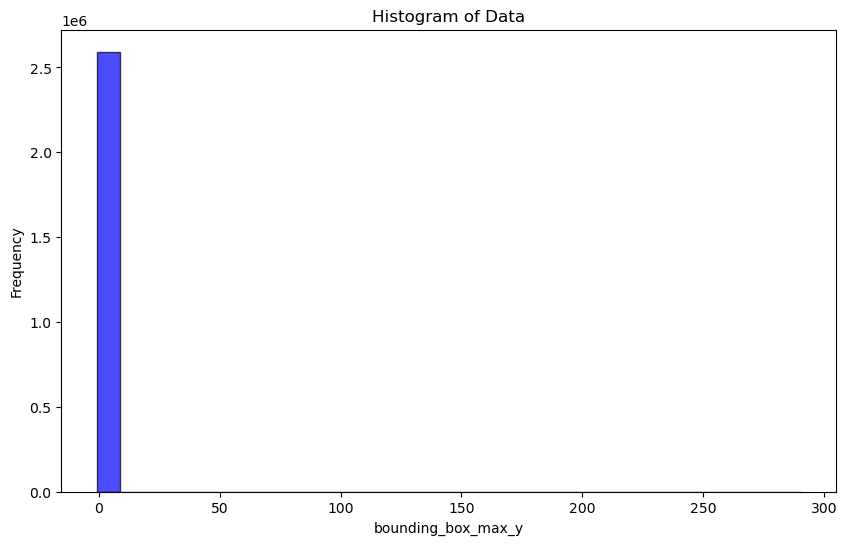

bounding_box_max_y 290.6419982910156


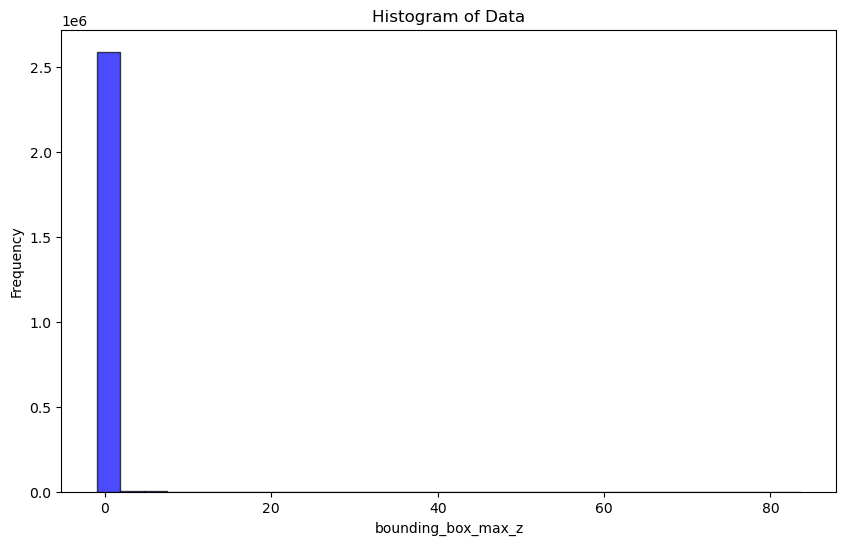

bounding_box_max_z 83.69090270996094


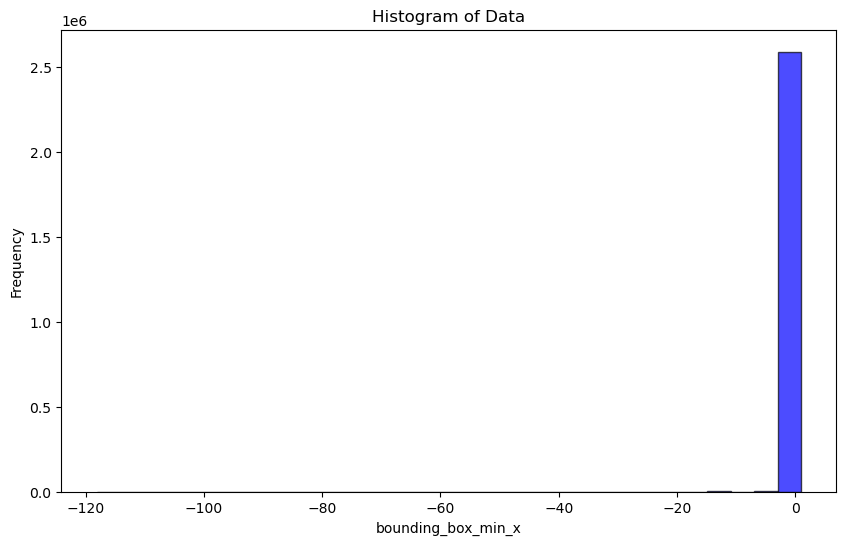

bounding_box_min_x 1.0000001192092896


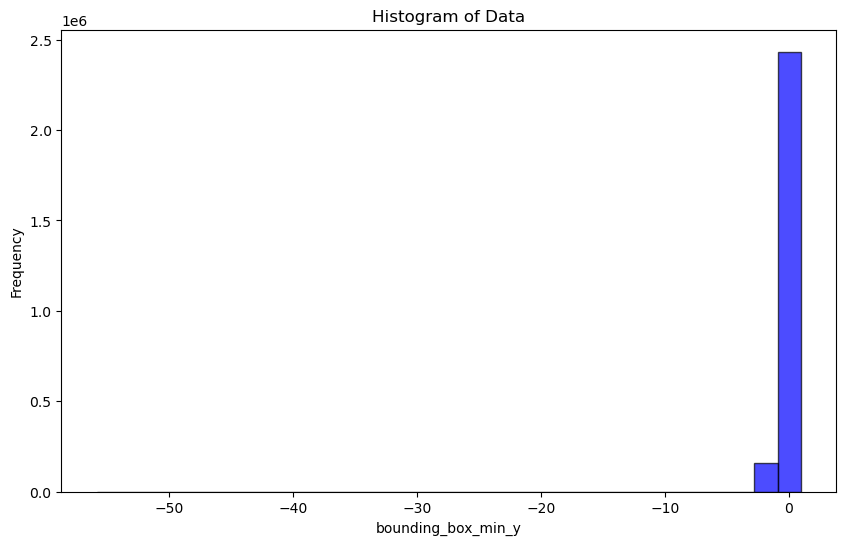

bounding_box_min_y 1.0000004768371582


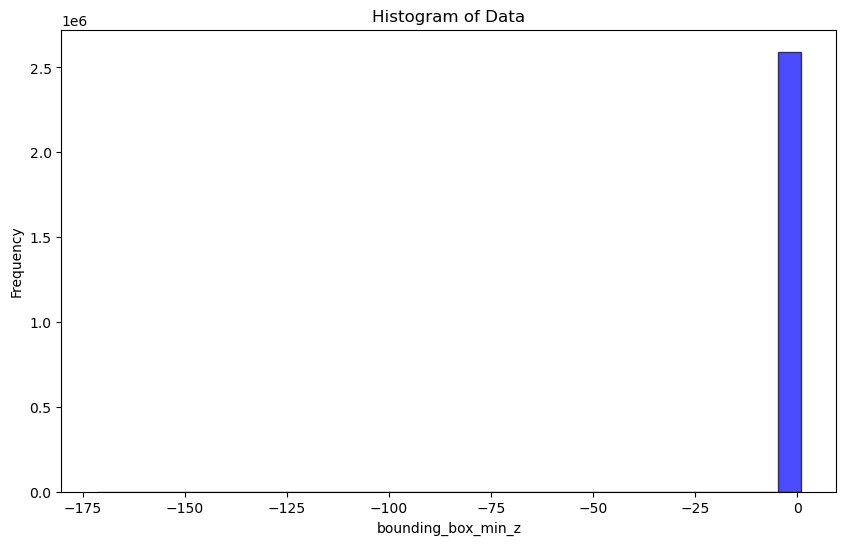

bounding_box_min_z 1.0000003576278687


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
for key, value in feature_to_values.items():
    plt.figure(figsize=(10, 6))
    plt.hist(value, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Histogram of Data')
    plt.xlabel(key)
    plt.ylabel('Frequency')
    plt.show()
    print(key, value.max())

In [21]:
face_features = [
    "param_1",
    "param_2",
]

edge_features = [
    "radius"
]

vector_features = [
    "axis_pos",
    "axis_dir"
]

for g1, g2, jg in dataset:
    g1_face_indices = torch.where(g1["is_face"] > 0.5)[0].long()
    g2_face_indices = torch.where(g2["is_face"] > 0.5)[0].long()
    g1_edge_indices = torch.where(g1["is_face"] < 0.5)[0].long()
    g2_edge_indices = torch.where(g2["is_face"] < 0.5)[0].long()
    flag = False
    # for feature in face_features:
    #     if g1[feature][g1_face_indices].numpy().max() > 2 or g2[feature][g2_face_indices].numpy().max() > 2:
    #         print(jg.joint_file_name, feature)
    #         flag = True
    #         break
    # if flag:
    #     continue

    # for feature in edge_features:
    #     if g1[feature][g1_edge_indices].numpy().max() > 2 or g2[feature][g2_edge_indices].numpy().max() > 2:
    #         print(jg.joint_file_name, feature)
    #         flag = True
    #         break
    # if flag:
    #     continue
    
    # for feature in vector_features:
    #     if g1[feature].numpy().max() > 2 or g2[feature].numpy().max() > 2:
    #         print(jg.joint_file_name, feature)
    #         flag = True
    #         break
    # if flag:
    #     continue

    if g1["length"][:].numpy().max() > 29:
        print(jg.joint_file_name, "g1")
    if g2["length"][:].numpy().max() > 29:
        print(jg.joint_file_name, "g2")

joint_set_00804.json g2
